## 1. Import Library
Notebook ini mengimplementasikan 3 model neural network untuk data tabular:
- MLP (Non-Pretrained)
- TabNet (Pretrained)
- FT-Transformer (Pretrained)


In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn torch pytorch-tabnet

Defaulting to user installation because normal site-packages is not writeable


In [34]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

## 2. Import library dan load data

Dataset merupakan data tabular dengan 445.132 baris dan 40 fitur.


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import os
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

df = pd.read_csv('heart_2022_with_nans.csv')

In [39]:
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


## 3. EDA
Target klasifikasi yang digunakan adalah **HadHeartAttack**.


C:\Users\an466\AppData\Local\Temp\ipykernel_15880\1551769648.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='HadHeartAttack', data=df, palette='viridis')


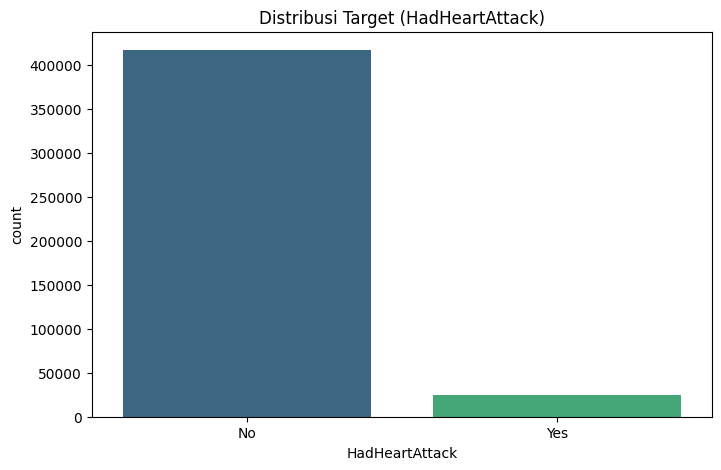

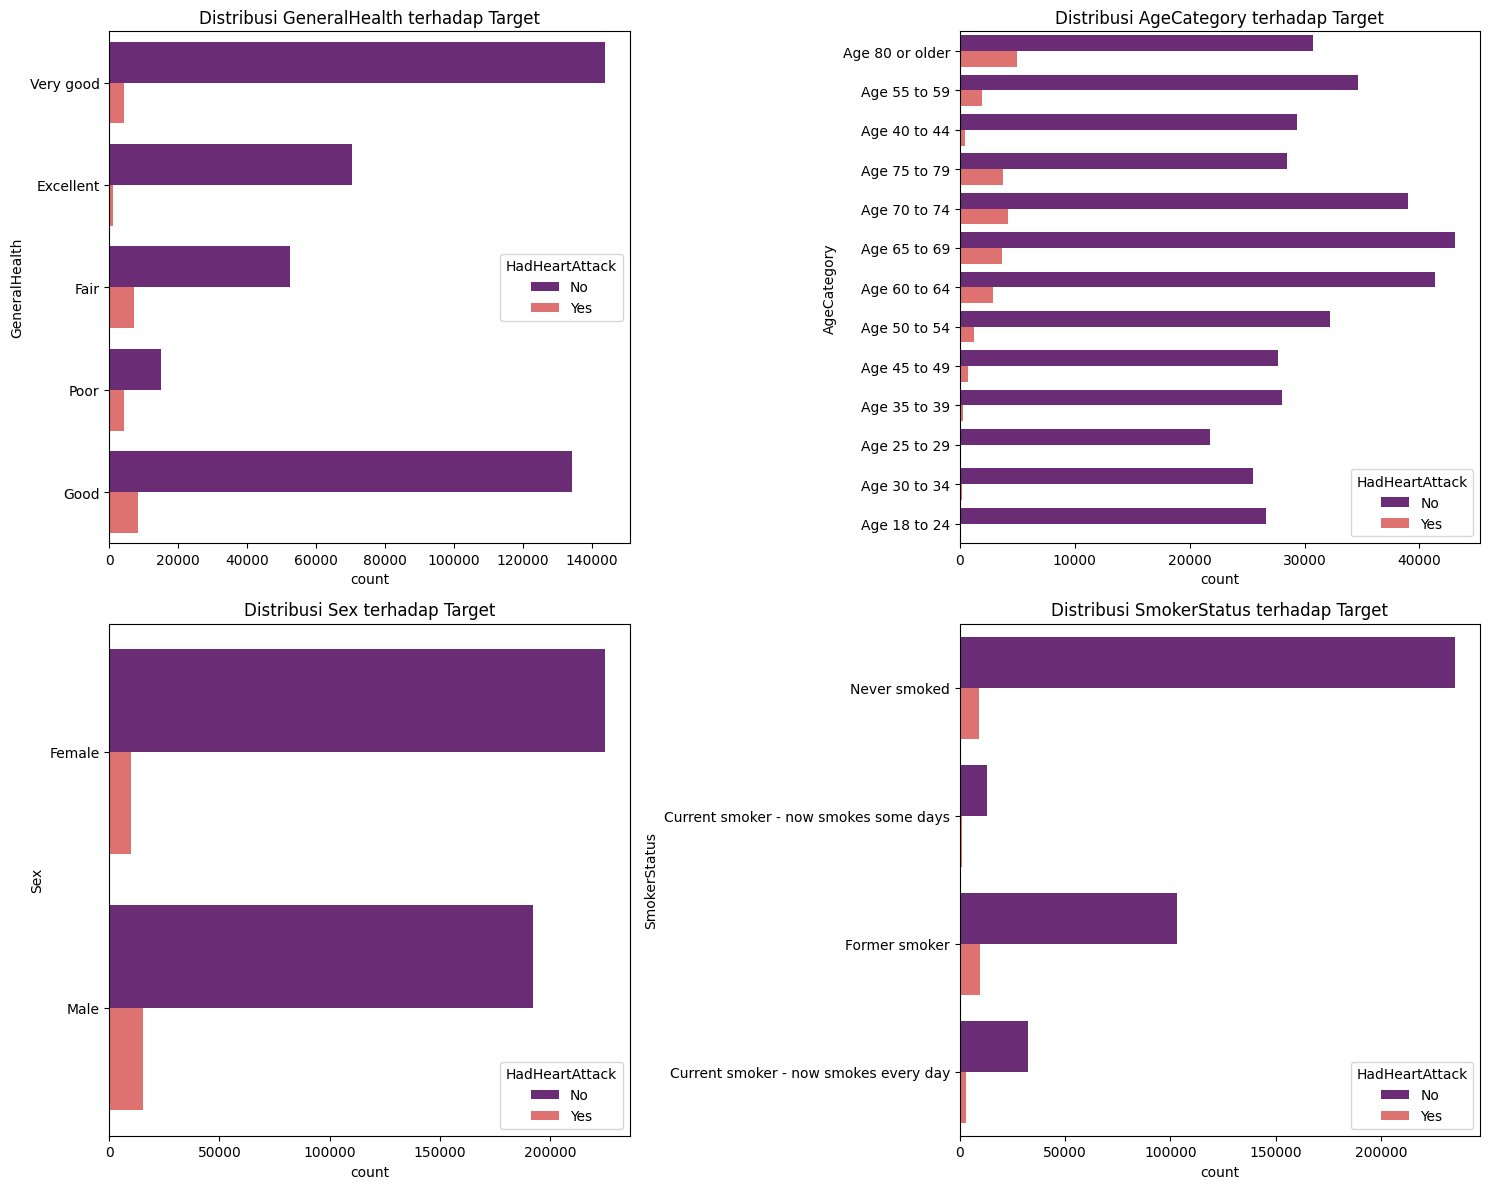

C:\Users\an466\AppData\Local\Temp\ipykernel_15880\1551769648.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HadHeartAttack', y='BMI', data=df, palette='Set2')


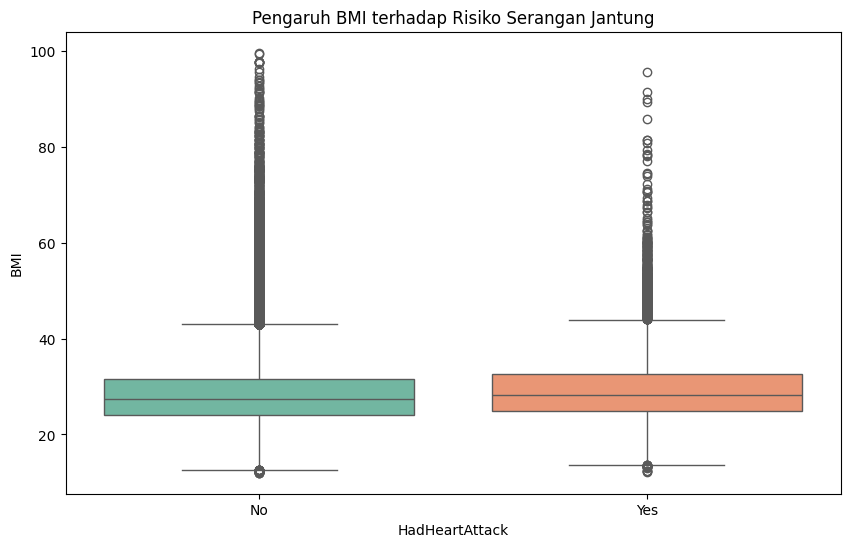

In [40]:
plt.figure(figsize=(8, 5))
sns.countplot(x='HadHeartAttack', data=df, palette='viridis')
plt.title('Distribusi Target (HadHeartAttack)')
plt.show()

key_features = ['GeneralHealth', 'AgeCategory', 'Sex', 'SmokerStatus']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for i, col in enumerate(key_features):
    sns.countplot(y=col, hue='HadHeartAttack', data=df, ax=axes[i//2, i%2], palette='magma')
    axes[i//2, i%2].set_title(f'Distribusi {col} terhadap Target')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='HadHeartAttack', y='BMI', data=df, palette='Set2')
plt.title('Pengaruh BMI terhadap Risiko Serangan Jantung')
plt.show()

## 4. Preprocessing



In [41]:
target_col = 'HadHeartAttack'
df = df.dropna(subset=[target_col])

numeric_cols = df.select_dtypes(include=['float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns.drop(target_col)

for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

le_target = LabelEncoder()
df[target_col] = le_target.fit_transform(df[target_col].astype(str))

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(weights, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)

X_train_t = torch.tensor(X_train_scaled.astype(np.float32)).to(device)
y_train_t = torch.tensor(y_train.values.astype(np.int64)).to(device)
X_val_t = torch.tensor(X_val_scaled.astype(np.float32)).to(device)
y_val_t = torch.tensor(y_val.values.astype(np.int64)).to(device)
X_test_t = torch.tensor(X_test_scaled.astype(np.float32)).to(device)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=1024, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=1024)

# 5. MLP

## 5.1

In [42]:
class BaseMLP(nn.Module):
    def __init__(self, input_dim):
        super(BaseMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)

mlp_model = BaseMLP(X_train_scaled.shape[1]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

mlp_history = {'loss': [], 'acc': []}

for epoch in range(15):
    mlp_model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        loss = criterion(mlp_model(batch_x), batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    mlp_model.eval()
    with torch.no_grad():
        preds = torch.max(mlp_model(X_val_t), 1)[1]
        acc = (preds == y_val_t).float().mean().item()
    
    mlp_history['loss'].append(total_loss/len(train_loader))
    mlp_history['acc'].append(acc)
    print(f"Epoch {epoch+1} - Loss: {mlp_history['loss'][-1]:.4f} - Val Acc: {acc:.4f}")

Epoch 1 - Loss: 0.4512 - Val Acc: 0.7951
Epoch 2 - Loss: 0.4313 - Val Acc: 0.7969
Epoch 3 - Loss: 0.4281 - Val Acc: 0.7854
Epoch 4 - Loss: 0.4254 - Val Acc: 0.7898
Epoch 5 - Loss: 0.4233 - Val Acc: 0.7921
Epoch 6 - Loss: 0.4223 - Val Acc: 0.7815
Epoch 7 - Loss: 0.4217 - Val Acc: 0.7994
Epoch 8 - Loss: 0.4204 - Val Acc: 0.7917
Epoch 9 - Loss: 0.4188 - Val Acc: 0.7981
Epoch 10 - Loss: 0.4185 - Val Acc: 0.8073
Epoch 11 - Loss: 0.4187 - Val Acc: 0.7959
Epoch 12 - Loss: 0.4168 - Val Acc: 0.7824
Epoch 13 - Loss: 0.4165 - Val Acc: 0.7842
Epoch 14 - Loss: 0.4152 - Val Acc: 0.7860
Epoch 15 - Loss: 0.4144 - Val Acc: 0.8091


## 5.2

EVALUASI MODEL 1: BASE MLP
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     62545
           1       0.20      0.78      0.32      3766

    accuracy                           0.81     66311
   macro avg       0.59      0.79      0.60     66311
weighted avg       0.94      0.81      0.86     66311



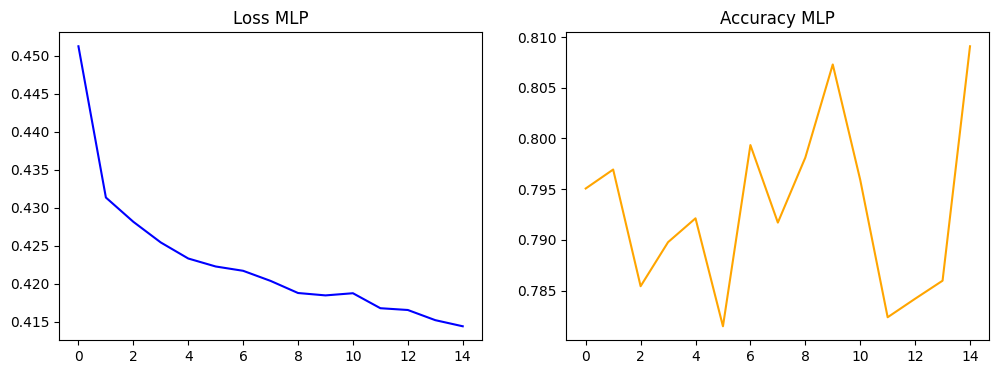

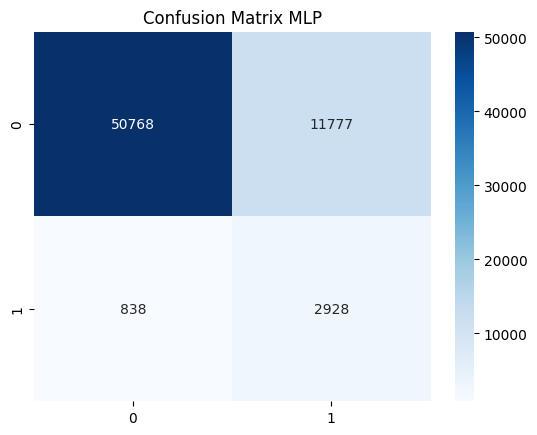

In [43]:
mlp_model.eval()
with torch.no_grad():
    y_pred_mlp = torch.max(mlp_model(X_test_t), 1)[1].cpu().numpy()

print("EVALUASI MODEL 1: BASE MLP")
print(classification_report(y_test, y_pred_mlp))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mlp_history['loss'], color='blue')
plt.title('Loss MLP')
plt.subplot(1, 2, 2)
plt.plot(mlp_history['acc'], color='orange')
plt.title('Accuracy MLP')
plt.show()

sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix MLP')
plt.show()

# 6 Tabnet

## 6.1

In [45]:
tabnet_pretrainer = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax'
)

tabnet_pretrainer.fit(
    X_train=X_train_scaled.astype(np.float32),
    eval_set=[X_val_scaled.astype(np.float32)],
    max_epochs=10,
    patience=3,
    batch_size=1024,
    virtual_batch_size=128
)

tabnet_model = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":5, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax'
)

tabnet_model.fit(
    X_train=X_train_scaled.astype(np.float32), 
    y_train=y_train.values.astype(np.int64),
    eval_set=[(X_val_scaled.astype(np.float32), y_val.values.astype(np.int64))],
    eval_name=['valid'],
    eval_metric=['accuracy'],
    max_epochs=15,
    patience=5,
    batch_size=1024,
    virtual_batch_size=128,
    from_unsupervised=tabnet_pretrainer,
    weights=1
)

C:\Users\an466\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00942 | val_0_unsup_loss_numpy: 0.8251100182533264|  0:00:29s
epoch 1  | loss: 0.90025 | val_0_unsup_loss_numpy: 0.7587500214576721|  0:00:57s
epoch 2  | loss: 0.87902 | val_0_unsup_loss_numpy: 0.7339800000190735|  0:01:25s
epoch 3  | loss: 0.87201 | val_0_unsup_loss_numpy: 0.7341399788856506|  0:01:53s
epoch 4  | loss: 0.87113 | val_0_unsup_loss_numpy: 0.7184100151062012|  0:02:21s
epoch 5  | loss: 0.86858 | val_0_unsup_loss_numpy: 0.7206900119781494|  0:02:48s
epoch 6  | loss: 0.8666  | val_0_unsup_loss_numpy: 0.722350001335144|  0:03:17s
epoch 7  | loss: 0.86645 | val_0_unsup_loss_numpy: 0.7163400053977966|  0:03:46s
epoch 8  | loss: 0.86477 | val_0_unsup_loss_numpy: 0.7163800001144409|  0:04:14s
epoch 9  | loss: 0.86285 | val_0_unsup_loss_numpy: 0.7152500152587891|  0:04:43s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_unsup_loss_numpy = 0.7152500152587891


C:\Users\an466\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\an466\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\an466\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.48606 | valid_accuracy: 0.78392 |  0:00:23s
epoch 1  | loss: 0.43227 | valid_accuracy: 0.8249  |  0:00:48s
epoch 2  | loss: 0.43123 | valid_accuracy: 0.81568 |  0:01:11s
epoch 3  | loss: 0.42373 | valid_accuracy: 0.78788 |  0:01:33s
epoch 4  | loss: 0.4229  | valid_accuracy: 0.77919 |  0:01:56s
epoch 5  | loss: 0.41975 | valid_accuracy: 0.78474 |  0:02:20s
epoch 6  | loss: 0.41916 | valid_accuracy: 0.8092  |  0:02:43s

Early stopping occurred at epoch 6 with best_epoch = 1 and best_valid_accuracy = 0.8249


C:\Users\an466\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## 6.2

EVALUASI MODEL 2: TABNET PRETRAINED
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     62545
           1       0.21      0.76      0.33      3766

    accuracy                           0.83     66311
   macro avg       0.60      0.79      0.62     66311
weighted avg       0.94      0.83      0.87     66311



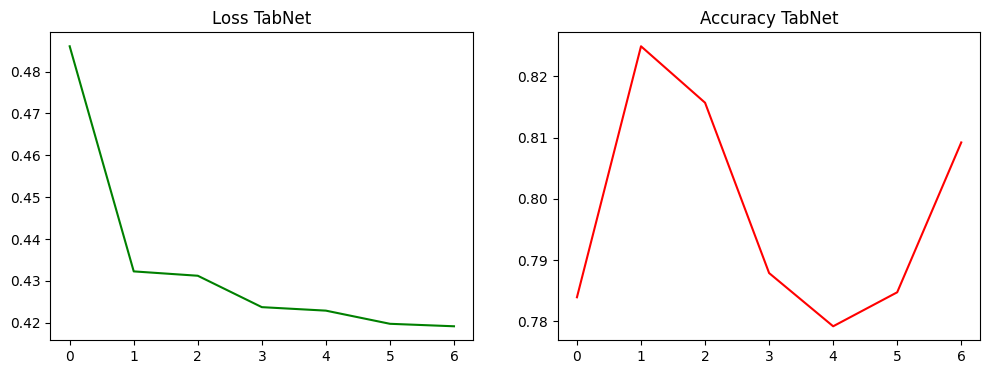

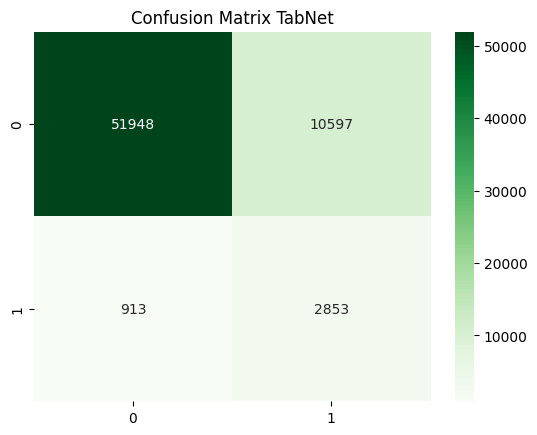

In [46]:
y_pred_tabnet = tabnet_model.predict(X_test_scaled.astype(np.float32))

print("EVALUASI MODEL 2: TABNET PRETRAINED")
print(classification_report(y_test, y_pred_tabnet))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(tabnet_model.history['loss'], color='green')
plt.title('Loss TabNet')
plt.subplot(1, 2, 2)
plt.plot(tabnet_model.history['valid_accuracy'], color='red')
plt.title('Accuracy TabNet')
plt.show()

sns.heatmap(confusion_matrix(y_test, y_pred_tabnet), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix TabNet')
plt.show()

# 7. Style NN

## 7.1

In [ ]:
class PretrainedStyleNN(nn.Module):
    def __init__(self, input_dim):
        super(PretrainedStyleNN, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.SiLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.SiLU()
        )
        self.head = nn.Linear(128, 2)
    def forward(self, x):
        x = self.features(x)
        return self.head(x)

pt_style_model = PretrainedStyleNN(X_train_scaled.shape[1]).to(device)
optimizer_pt = optim.Adam(pt_style_model.parameters(), lr=0.0005)
pt_history = {'loss': [], 'acc': []}

for epoch in range(15):
    pt_style_model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer_pt.zero_grad()
        loss = criterion(pt_style_model(batch_x), batch_y)
        loss.backward()
        optimizer_pt.step()
        total_loss += loss.item()
    
    pt_style_model.eval()
    with torch.no_grad():
        preds = torch.max(pt_style_model(X_val_t), 1)[1]
        acc = (preds == y_val_t).float().mean().item()
    
    pt_history['loss'].append(total_loss/len(train_loader))
    pt_history['acc'].append(acc)
    print(f"Epoch {epoch+1} - Loss: {pt_history['loss'][-1]:.4f} - Val Acc: {acc:.4f}")

Epoch 1 - Loss: 0.4528 - Val Acc: 0.8140
Epoch 2 - Loss: 0.4347 - Val Acc: 0.8114
Epoch 3 - Loss: 0.4326 - Val Acc: 0.8097
Epoch 4 - Loss: 0.4308 - Val Acc: 0.8005
Epoch 5 - Loss: 0.4290 - Val Acc: 0.8111
Epoch 6 - Loss: 0.4291 - Val Acc: 0.8075
Epoch 7 - Loss: 0.4281 - Val Acc: 0.7992
Epoch 8 - Loss: 0.4271 - Val Acc: 0.8067
Epoch 9 - Loss: 0.4269 - Val Acc: 0.8117
Epoch 10 - Loss: 0.4256 - Val Acc: 0.8031
Epoch 11 - Loss: 0.4253 - Val Acc: 0.7968
Epoch 12 - Loss: 0.4245 - Val Acc: 0.8072
Epoch 13 - Loss: 0.4248 - Val Acc: 0.8118
Epoch 14 - Loss: 0.4241 - Val Acc: 0.8143
Epoch 15 - Loss: 0.4231 - Val Acc: 0.8046


## 7.2.

EVALUASI MODEL 3: PRETRAINED STYLE NN
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     62545
           1       0.19      0.78      0.31      3766

    accuracy                           0.80     66311
   macro avg       0.59      0.79      0.60     66311
weighted avg       0.94      0.80      0.85     66311



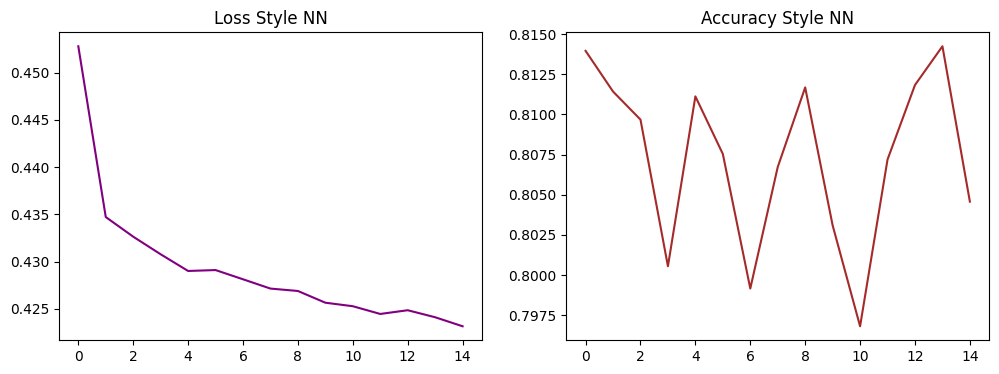

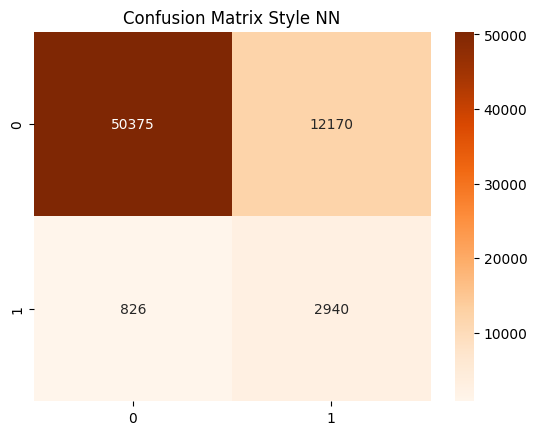

In [49]:
pt_style_model.eval()
with torch.no_grad():
    y_pred_pt = torch.max(pt_style_model(X_test_t), 1)[1].cpu().numpy()

print("EVALUASI MODEL 3: PRETRAINED STYLE NN")
print(classification_report(y_test, y_pred_pt))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(pt_history['loss'], color='purple')
plt.title('Loss Style NN')
plt.subplot(1, 2, 2)
plt.plot(pt_history['acc'], color='brown')
plt.title('Accuracy Style NN')
plt.show()

sns.heatmap(confusion_matrix(y_test, y_pred_pt), annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix Style NN')
plt.show()

In [50]:
os.makedirs('src/models', exist_ok=True)
joblib.dump(X.columns.tolist(), 'src/models/feature_names.pkl')

df_raw = pd.read_csv('heart_2022_with_nans.csv')
clean_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    valid_labels = [str(x) for x in df_raw[col].dropna().unique()]
    le.fit(valid_labels)
    clean_encoders[col] = le

joblib.dump(clean_encoders, 'src/models/label_encoders.pkl')
joblib.dump(scaler, 'src/models/scaler.pkl')
torch.save(mlp_model.state_dict(), 'src/models/mlp_model.pth')
torch.save(pt_style_model.state_dict(), 'src/models/pt_style_model.pth')
tabnet_model.save_model('src/models/tabnet_model')

Successfully saved model at src/models/tabnet_model.zip


'src/models/tabnet_model.zip'